In [29]:
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
#!pip install torch_geometric
#!pip install pyvista
#%pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html
#%pip install pyvista==0.44.1

In [30]:
import torch
from torch_geometric.data import Data
import pyvista as pv
from utils import *
torch.__version__, pv.__version__

('2.0.1+cu117', '0.44.1')

In [31]:
data = torch.load('./sampleData.pth')
data.edge_index = np.empty((2, 0))
transform = DelaunayTransform()
data = transform(data)
def plot_graph(data, l=1, plotter=None, node_colors=None):
    
    c = ['r', 'g', 'b', 'm']
    
    p = pv.Plotter() if plotter is None else plotter
    
    # Création d'un PolyData pour les points (nœuds)
    mesh = pv.PolyData()
    
    # Gestion des dimensions des positions
    if data.pos.shape[1] != 3:
        # Ajouter une troisième dimension si nécessaire
        mesh.points = np.concatenate([data.pos.cpu().numpy(), np.full((data.pos.shape[0], 1), l)], axis=1)
    else:
        mesh.points = data.pos.cpu().numpy()

    # Création des lignes pour les arêtes
    edges = data.edge_index.t().cpu().numpy()
    lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
    mesh.lines = lines
    
    
    # Ajout des couleurs au PolyData
    mesh.point_data['values'] = node_colors if node_colors is not None else np.random.randint(0, 255, size=(data.pos.shape[0], 3))
    
    # Ajouter le mesh avec les couleurs des nœuds
    p.add_mesh(mesh, scalars='values', line_width=0.5, point_size=0.3, render_points_as_spheres=True)

    # Si aucun plotter n'a été fourni, on montre la figure
    if plotter is None:
        p.show()
        
data.edge_index.shape

torch.Size([2, 1019114])

In [32]:
    
def generate_coarse_graphs(data, R: int, K: int, visualize=False):
    data = data.cpu() # Quicker to compute on CPU
    range_ = 5000
    edge_clusters, new_cluster_nodes = divide_mesh(data.pos, data.edge_index.T, K)
    data.clusters = edge_clusters
    data.node_clusters = new_cluster_nodes
    base = data.clone()
    base.R = R
    base.clusters_per_layer = K
    base.edge_frequencies = []
    base.layer_ranges = torch.zeros((R, 2), device=base.pos.device, dtype=torch.int)
    base.layer_ranges[0] = torch.tensor([0, base.pos.shape[0]], device=base.pos.device)
    base.up_scale_edge_ranges = torch.zeros((R-1, 2), device=base.pos.device, dtype=torch.int)
    if visualize:
        base.pos = torch.concatenate([base.pos, torch.full((base.pos.shape[0], 1), 1, device=base.pos.device)], axis=1)
    s = [base.pos.shape[0]]
    for i in range(2, R+1):
        subgraph, connection_index, new_clusters_edges, edge_frequencies, new_cluster_nodes = generate_coarse_graph(data, range_//(7**i), base.clusters_per_layer) # TODO: choose the right scale factor
        base.edge_frequencies.append(edge_frequencies)
        # We add the new node clusters indexed in the subgraph
        base.node_clusters.extend(new_cluster_nodes)
        # We add the new clusters edge indices indexed in the subgraph 
        base.clusters.extend([c + base.edge_index.shape[1] for c in new_clusters_edges])

        data = subgraph.clone()
        s.append(subgraph.pos.shape[0])        
        
        
        # We need to add the new dimension to the positions to visualize them
        if visualize:
            subgraph.pos = torch.concatenate([subgraph.pos, torch.full((subgraph.pos.shape[0], 1), i, device=subgraph.pos.device)], axis=1) # TODO: remove it

        # We need to add the new edges to the base graph so the new nodes ids have to be shifted by the number of nodes in the base graph
        subgraph.edge_index = torch.add(subgraph.edge_index, base.pos.shape[0])
        
        # We need to connect the new nodes to the base graph nodes
        connection_index = torch.add(connection_index, sum(s[:-2]))

        base.pos = torch.cat([base.pos, subgraph.pos], dim=0) # TODO: use barycentric interpolation
        base.surf = torch.cat([base.surf, subgraph.surf], dim=0) 
        base.x = torch.cat([base.x, subgraph.x], dim=0)
        base.edge_index = torch.cat([base.edge_index, subgraph.edge_index, connection_index], dim=1)
        
        base.up_scale_edge_ranges[i-2] = torch.tensor([base.edge_index.shape[1]-connection_index.shape[1], base.edge_index.shape[1]], device=base.pos.device)
        base.layer_ranges[i-1] = torch.tensor([base.pos.shape[0]-subgraph.pos.shape[0]-1, base.pos.shape[0]], device=base.pos.device)
        if i >= R:
            last_one_frequencies = torch.full((K,), 9, device=base.pos.device, dtype=torch.int) 
            base.edge_frequencies.append(last_one_frequencies)
    return base


In [33]:
#%%timeit
divide_mesh(data.pos, data.edge_index.T, 6)

([tensor([      0,      31,      32,  ..., 1019096, 1019100, 1019113]),
  tensor([     36,      37,      74,  ..., 1019110, 1019111, 1019112]),
  tensor([     20,      21,      22,  ..., 1019093, 1019097, 1019101]),
  tensor([      1,       2,       3,  ..., 1018970, 1018971, 1018976]),
  tensor([   1819,    1884,    1910,  ..., 1019011, 1019015, 1019032]),
  tensor([     13,      14,      15,  ..., 1019102, 1019103, 1019104])],
 [tensor([     0,      1,      2,  ..., 170177, 170178, 170179]),
  tensor([     1,      3,      5,  ..., 170167, 170168, 170179]),
  tensor([     0,      1,      2,  ..., 170177, 170178, 170179]),
  tensor([     0,      1,      2,  ..., 170177, 170178, 170179]),
  tensor([     1,      3,      5,  ..., 170167, 170168, 170179]),
  tensor([     0,      1,      2,  ..., 170177, 170178, 170179])])

In [34]:
import matplotlib.pyplot as plt

#plot_graph(data)

In [35]:
device = torch.device('cuda')
b = generate_coarse_graphs(data, R=3, K=6)
b.edge_frequencies

[tensor([16, 11, 13, 17, 15, 12], dtype=torch.int32),
 tensor([22, 16, 22,  7, 16,  7], dtype=torch.int32),
 tensor([9, 9, 9, 9, 9, 9], dtype=torch.int32)]

/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


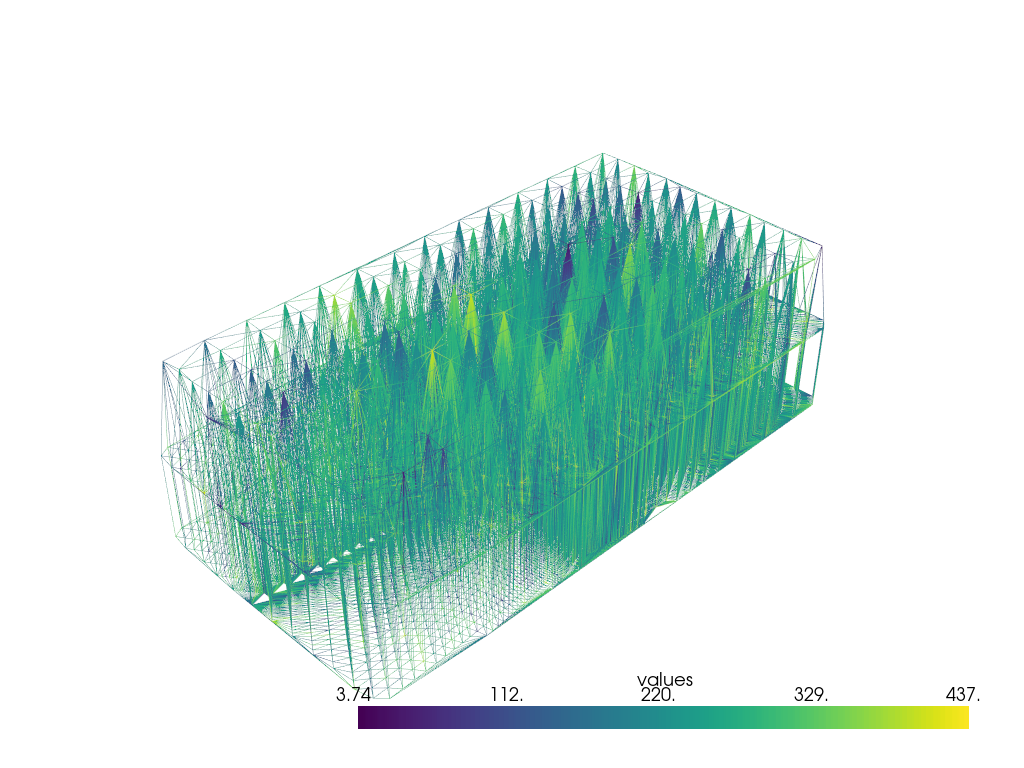

In [36]:
device = torch.device('cuda')
b = generate_coarse_graphs(data, R=3, K=6, visualize=True)
plot_graph(b)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
b = b.to(device)
b.layer_ranges

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
#%%timeit
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
import importlib
import my_model
importlib.reload(my_model)

# Reload the model
model = my_model.UaMgnn(5, 4, R=3, K=5, device=device)
print("N nodes: ", b.pos.shape[0], "N edges: ", b.edge_index.shape[1])
model(b).shape

N nodes:  190702 N edges:  1329524


/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [634,0,0], thread: [64,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [634,0,0], thread: [65,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [634,0,0], thread: [66,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [634,0,0], thread: [67,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/nat

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [61]:
#color = torch.tensor([0.0], device=device)
#colors = color.repeat(b.pos.shape[0], 1)
#colors[torch.logical_not(b.surf)] = torch.tensor([1.0], device=device)
#print(torch.mean(colors, dim=0), flush=True)
#plot_graph(b, l=1, node_colors=colors.cpu().numpy())


In [4]:
edge_index = torch.IntTensor([
    [0, 1, 2, 3],
    [1, 2, 3, 4]
])   

node_index = torch.IntTensor([0, 1, 2, 3, 4])
nodes_index_of_subgraph = torch.IntTensor([0, 1, 3, 4])
edge_indices_of_subgraph = torch.IntTensor([0, 3])

mask = torch.full((node_index.shape[0],), 1, dtype=torch.int32)
mask[nodes_index_of_subgraph] = 0

mask = torch.cumsum(mask, dim=0)
edge_of_subgraph = edge_index[:, edge_indices_of_subgraph]
edge_of_subgraph -= mask[edge_of_subgraph]

edge_of_subgraph

tensor([[0, 2],
        [1, 3]], dtype=torch.int32)